# Test Script - Random Forest Regressor

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from utils import StepWiseDecay as SWD
import utils
import pickle
import random
import time

from sklearn.model_selection import GridSearchCV
from sklearnex.ensemble import RandomForestRegressor


from modAL.models import BayesianOptimizer, CommitteeRegressor
from modAL.acquisition import max_EI, max_PI, max_UCB

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
# parameters
fingerprint = 'morgan'
model = 'RFR'
file_name = "complete_file_morgan.feather"
config_file_name = 'RFR.json'
use_unified_file = True
assay_limit = 500

## Helper Functions

In [3]:
random.seed(42)
file_path = '/data_temp/default_{}/'.format(fingerprint)

try:
    if use_unified_file == True:
        try:
            df = pd.read_feather("../data" + file_path + file_name)
        except:
            df = pd.read_parquet("../data" + file_path + file_name)
        df_nan = pd.read_parquet("../data" + file_path + "assay_id/assay_id_null_file.parquet")
        df_assays = pd.read_parquet("../data" + file_path + "assay_id/assay_id_file.parquet")

    elif use_unified_file == False:
        df_fingerprint = pd.read_parquet("../" + file_path + "/fingerprint/{}_fingerprint_file.parquet".format(fingerprint))
        df = pd.read_parquet("../" + file_path + "/preprocessed/preprocessed_file.parquet")
        df_nan = pd.read_parquet("../" + file_path + "/assay_id/assay_id_null_file.parquet")
        df_assays = pd.read_parquet("../" + file_path + "/assay_id/assay_id_file.parquet")
    else:
        print("Incorrect value for 'use_unified_file' parameter passed. Please recheck.")
        pass
except:
    print("Data File not found")

In [4]:
df_nan.loc[df_nan['squared_pearson_trn'].isnull()]

,assay_id,squared_pearson_trn,squared_pearson_tst,assay_length_trn,assay_length_tst,assay_length_total
1,303216,NaN,NaN,45,15,60
2,303260,NaN,NaN,45,15,60
4,737235,NaN,NaN,45,15,60


In [5]:
# df = df.drop(nan_assays)
for i in df_nan.loc[df_nan['squared_pearson_trn'].isnull()]['assay_id']:
    df = df.drop(labels = df.loc[df['assay_id']==i].index)
df.loc[df['assay_id']==303216].head()
print('x-----x-----x-----x')
df.loc[df['assay_id']==303260].head()
print('x-----x-----x-----x')
df.loc[df['assay_id']==737235].head()
print('x-----x-----x-----x')

x-----x-----x-----x
x-----x-----x-----x
x-----x-----x-----x


In [6]:
# Loading JSON config file
try:
    with open('../config/' + config_file_name) as f:
        params_config = json.load(f)
        print('JSON config file for {} successfully loaded'.format(model))
except FileNotFoundError:
    print('Config file for model {} is missing.Resorting to default params'.format(model))
    with open('../config/{}_default.json'.format(model)) as f:
        params_config = json.load(f)
try:
    with open('../config/decay_values.json') as f:
        decay_list = json.load(f)
        decay_list = decay_list["decay values"]
except:
    decay_list = [1.0,0.75,0.5,0.25,0.125,0.1,0.05]
    print('Config file for decay values is missing. Resorting to default values: {}'.format(decay_list))
            
if os.path.isdir('../models/{0}_{1}/'.format(model,fingerprint)) == False:
    os.mkdir('../models/{0}_{1}/'.format(model,fingerprint))

if os.path.isdir('../data/data_results/{0}_{1}/'.format(model,fingerprint)) == False:
    os.mkdir('../data/data_results/{0}_{1}/'.format(model,fingerprint))

if os.path.isdir('../data/data_results/{0}_{1}/plots'.format(model,fingerprint)) == False:
    os.mkdir('../data/data_results/{0}_{1}/plots'.format(model,fingerprint))

# Creating List of Classifiers
clfs = []
acquisition_list = []
clf_list = []
count = 0
clf_list_names = []

for ensemble_kernel in params_config["model"]:
    if ensemble_kernel == "RandomForestRegressor()":
        clf_type = RandomForestRegressor(n_estimators=params_config["params"]["n_estimators"],
                                            criterion=params_config["params"]["criterion"],
                                            min_samples_leaf=params_config["params"]["min_samples_leaf"],
                                            n_jobs=-1)
    else:
        clf_type = RandomForestRegressor(n_jobs=-1)
    clf = {
        "type" : clf_type,
        "name" : ensemble_kernel
    }
    clfs.append(clf)

for function in params_config["acquisition"]:
    if function=="max_EI":
        acquisition_type = max_EI
    elif function=="max_PI":
        acquisition_type = max_PI
    elif function=="max_UCB":
        acquisition_type = max_UCB
    elif function=="random":
        acquisition_type = utils.random_sampling
    elif function=="equivalent":
        acquisition_type = utils.equivalent_sampling
    elif function=="margin_entropy":
        acquisition_type = utils.margin_entropy_sampling
    elif function=="uncertainty_margin":
        acquisition_type = utils.uncertainty_margin_sampling
    elif function=="product_sampling":
        acquisition_type = utils.product_sampling
    else:
        acquisition_type = max_EI
    acquisition = {
        "type" : acquisition_type,
        "name": function
    }
    acquisition_list.append(acquisition)

for model_selected in clfs:
    for ac_func in acquisition_list:
        clf = {
            "model" :model_selected["type"],
            "model_name" : model_selected["name"],
            "acquisition_function" :ac_func["type"],
            "acquisition_function_name" : ac_func["name"]
        }
        clf_list.append(clf)
        clf_list_names.append("model_{}_{}".format(clf["model_name"], clf["acquisition_function_name"]))
        count+=1

clf_list_names = ['assay_id','subset_size','total_length'] + clf_list_names

num_iterations=params_config["iterations"]

JSON config file for RFR successfully loaded


In [7]:
pearson_trn = [[0 for i in range(len(clf_list)+3)] for j in range(len(df["assay_id"].unique()+1))]
pearson_tst = [[0 for i in range(len(clf_list)+3)] for j in range(len(df["assay_id"].unique()+1))]

pearson_values_graph = [[0 for i in range(len(acquisition_list))] for j in range(num_iterations)]


In [8]:
import warnings
warnings.simplefilter('ignore')

In [9]:
params_config["num_committee"]

5

In [11]:
list_subset_sizes = []
list_total_sizes = []
row = 0
column = 0
pvg_column = 0
pvg_row = 0

# flag_first_assay = 688239
# flag_first_assay = 517
flag_first_assay = 70695

try:
    decay_tracker = SWD(decay_list)
    count = 0

    for assay_id in df['assay_id'].unique():

        df_current = df.loc[df['assay_id']==assay_id]
        df_train = df_current.loc[df['Clustering']=='TRN']
        df_tst = df_current.loc[df['Clustering']=='TST']
        column=0
        pvg_column = 0
        
        if assay_id != np.int64(flag_first_assay):
            continue
        start = time.time()


        
        subset_size = int(decay_tracker.calculate(df_train.shape[0])*df_train.shape[0])
        list_subset_sizes.append(subset_size)
        list_total_sizes.append(df_train.shape[0])

        pearson_trn[row][column] = assay_id
        pearson_tst[row][column] = assay_id
        column+=1

        X = np.array(df_train.iloc[:,10:])[:subset_size]
        y = np.array(df_train.iloc[:,3])[:subset_size]


        pearson_trn[row][column] = subset_size
        pearson_tst[row][column] = subset_size
        column+=1

        pearson_trn[row][column] = df_train.shape[0]
        pearson_tst[row][column] = df_tst.shape[0]
        column+=1
        
        if use_unified_file==True:
            for gpr_model in clf_list:
                if assay_id==np.int64(flag_first_assay):
                    print("Data is for model {} with acc_func {}".format(gpr_model["model_name"], gpr_model["acquisition_function_name"]))
                learner_list = []
                X_train = X
                y_train = y
                for member_idx  in range(params_config["num_committee"]):
                    # print("Shape of matrices: ",X_train.shape,int(df_train.shape[0]*0.1),int(X.shape[0]*0.1))
                    train_idx = np.random.choice(range(X_train.shape[0]), size=int(X.shape[0]*0.1), replace=False)
                    

                    x_initial = X_train[train_idx]
                    y_initial = y_train[train_idx]

                    X_train = np.delete(X_train,train_idx, axis=0)
                    y_train = np.delete(y_train,train_idx)

                    # print(x_initial.shape, y_initial.shape)
                    clf = gpr_model["model"]
                    learner = BayesianOptimizer(
                        estimator=GridSearchCV(clf,params_config["param_grid"],n_jobs=-1,cv=5 if 5 < int(x_initial.shape[0]) else int(x_initial.shape[0])),
                        query_strategy=gpr_model["acquisition_function"],
                        X_training=x_initial, y_training=y_initial
                    )
                    learner_list.append(learner)
                
                committee = CommitteeRegressor(learner_list=learner_list)
                print('Completed Generation of Committee object.')

                pvg_row=0
                for n_query in range(num_iterations):
                    if assay_id==np.int64(flag_first_assay):
                        first_assay = assay_id
                        predictions_first_assay = committee.predict(np.array(df_train.iloc[:,10:]))
                        pearson_values_graph[pvg_row][pvg_column] = round(np.corrcoef(np.array(df_train.iloc[:,3]), predictions_first_assay)[0,1]**2,5)
                        pvg_row+=1
                    
                    query_idx,query_inst = committee.query(X_train, n_instances=20)

                    committee.teach(X=query_inst,y=y_train[query_idx])
                
                with open('../models/{0}_{1}/{2}_{3}_{4}.pickle'.format(model,fingerprint,gpr_model["model_name"],gpr_model["acquisition_function_name"],assay_id),'wb') as f:
                    pickle.dump(committee,f)
                
                with open('../models/{0}_{1}/{2}_{3}_{4}.pickle'.format(model,fingerprint,gpr_model["model_name"],gpr_model["acquisition_function_name"],assay_id),'rb') as f:
                     learner = pickle.load(f)
                
                predictions = committee.predict(np.array(df_train.iloc[:,10:]))
                result_trn = round(np.corrcoef(np.array(df_train.iloc[:,3]), predictions)[0,1]**2,5)

                predictions = committee.predict(np.array(df_tst.iloc[:,10:]))
                result_tst = round(np.corrcoef(np.array(df_tst.iloc[:,3]), predictions)[0,1]**2,5)

                pearson_trn[row][column] = result_trn
                pearson_tst[row][column] = result_tst
                
                column+=1
                pvg_column+=1
        else:
            print("Feature is in the works.")   
        row+=1
        count+=1
        print("Assays {} parsed".format(count))
        if count >= assay_limit:
             break

except NameError:
    print('Key Error')

Data is for model RandomForestRegressor() with acc_func max_UCB
Completed Generation of Committee object.
Data is for model RandomForestRegressor() with acc_func max_PI
Completed Generation of Committee object.
Data is for model RandomForestRegressor() with acc_func max_EI
Completed Generation of Committee object.
Assays 1 parsed


In [12]:
print('Reached selected assay at time = {}'.format(time.time() - start))

Reached selected assay at time = 1178.8143899440765


In [13]:
pearson_values_graph

[[0.358, 0.41166, 0.34907],
 [0.60722, 0.53088, 0.49511],
 [0.66133, 0.56727, 0.59985],
 [0.70534, 0.53921, 0.60219],
 [0.71096, 0.51987, 0.57475],
 [0.68689, 0.52948, 0.55737],
 [0.68744, 0.49022, 0.54679],
 [0.67633, 0.50206, 0.53886],
 [0.68721, 0.49476, 0.51303],
 [0.67103, 0.47867, 0.53072],
 [0.66886, 0.44185, 0.5064],
 [0.6773, 0.47068, 0.51937],
 [0.6678, 0.46129, 0.50525],
 [0.67913, 0.46774, 0.50965],
 [0.66323, 0.44984, 0.50047],
 [0.6564, 0.44705, 0.47197],
 [0.65285, 0.44706, 0.49425],
 [0.65171, 0.42735, 0.48224],
 [0.65588, 0.45989, 0.46291],
 [0.65561, 0.4248, 0.46817],
 [0.64631, 0.42882, 0.46778],
 [0.64043, 0.444, 0.45682],
 [0.64632, 0.40874, 0.45252],
 [0.6432, 0.40182, 0.43619],
 [0.64178, 0.41029, 0.46154]]

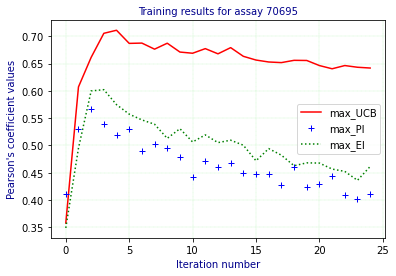

In [14]:
pd.DataFrame(pearson_trn, columns=clf_list_names).to_csv('../data/data_results/{0}_{1}/pearsons_training_set_{2}.csv'.format(model,fingerprint,num_iterations),index=False)
pd.DataFrame(pearson_tst, columns=clf_list_names).to_csv('../data/data_results/{0}_{1}/pearsons_test_set_{2}.csv'.format(model,fingerprint,num_iterations),index=False)

pearson_values_graph = pd.DataFrame(pearson_values_graph, columns=params_config["acquisition"])
pearson_values_graph.to_csv('../data/data_results/{0}_{1}/squared_pearson_{2}.csv'.format(model,fingerprint,flag_first_assay),index=False)

colours = ['-r','+b',':g','^y','--p']
colour_count = 0
font_custom = {
    "family" : "sans-serif",
    "color" : "darkblue",
    "size" : "10"
    }

plt.title("Training results for assay {}".format(flag_first_assay), fontdict=font_custom, loc='center')
plt.xlabel("Iteration number", fontdict=font_custom)
plt.ylabel("Pearson's coefficient values", fontdict=font_custom)


for (column_name,column_contents) in pearson_values_graph.iteritems():
    plt.plot([x for x in range(len(column_contents))],column_contents, colours[colour_count], label='{}'.format(column_name))
    colour_count +=1
plt.grid(color = 'lightgreen', linestyle = '--', linewidth =0.25)
plt.legend()
plt.savefig('../data/data_results/{0}_{1}/plots/training_cycles_{2}.jpg'.format(model,fingerprint,flag_first_assay),
                format='jpg',
               )
plt.show()